In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta

In [2]:
def get_data():
    #Depende de la función de las chicas
    data_ind= pd.read_excel('raw_data/weekly_data_clean_with_covid_ind.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')
    data_col= pd.read_excel('raw_data/weekly_data_clean_with_covid_col.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')
    return data_col, data_ind

def plot_future_forecast(past_data, prediction, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    prediction = pd.Series(prediction[0], index=prediction.index)
    lower_series = pd.Series(upper, index=prediction.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=prediction.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(past_data, label='past_data', color='black')
    plt.plot(prediction, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast')
    plt.legend(loc='upper left', fontsize=8);

def plot_future_forecast_total(past_data, prediction, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    prediction = pd.Series(prediction, index=prediction.index)
    lower_series = pd.Series(upper, index=prediction.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=prediction.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(past_data, label='past_data', color='black')
    plt.plot(prediction, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast')
    plt.legend(loc='upper left', fontsize=8);

def predict_col(data_col, end_date):
    # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_col['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_col.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data_col = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data_col = future_prediction_full_data.conf_int(alpha=0.05)
    # Returning prediction and CI
    return future_predicted_amount_df_full_data_col, future_pred_ci_full_data_col

def predict_ind(data_ind, end_date):
    # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_ind['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_ind.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data_ind = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data_ind = future_prediction_full_data.conf_int(alpha=0.05)
    # Returning prediction and CI
    return future_predicted_amount_df_full_data_ind, future_pred_ci_full_data_ind

def predict_total(data_col, data_ind, end_date):
    future_predicted_amount_df_full_data_col, future_pred_ci_full_data_col = predict_col(data_col, end_date)
    future_predicted_amount_df_full_data_ind, future_pred_ci_full_data_ind = predict_ind(data_ind, end_date)

    merged_pred = future_predicted_amount_df_full_data_col.merge(future_predicted_amount_df_full_data_ind, right_index=True, left_index=True)
    merged_pred['total_pred']= merged_pred['0_x'] + merged_pred['0_y']
    merged_ci = future_pred_ci_full_data_col.merge(future_pred_ci_full_data_ind, right_index=True, left_index=True)
    merged_ci['total_lower_amount'] = merged_ci['lower amount_x'] + merged_ci['lower amount_y']
    merged_ci['total_upper_amount'] = merged_ci['upper amount_x'] + merged_ci['upper amount_y']
    return merged_pred, merged_ci



def plot_predict_col(data_col, end_date):
    # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_col['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_col.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data = future_prediction_full_data.conf_int(alpha=0.05)
    # Plotting
    return plot_future_forecast(data_col['amount'], future_predicted_amount_df_full_data, upper= future_pred_ci_full_data['upper amount'].values, lower= future_pred_ci_full_data['lower amount'].values)

def plot_predict_ind(data_ind, end_date):
     # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_ind['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_ind.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data = future_prediction_full_data.conf_int(alpha=0.05)
    # Plotting
    return plot_future_forecast(data_ind['amount'], future_predicted_amount_df_full_data, upper= future_pred_ci_full_data['upper amount'].values, lower= future_pred_ci_full_data['lower amount'].values)

def plot_predict_total(data_col, data_ind, end_date):
    total_df = data_col.merge(data_ind, right_index=True, left_index=True)
    total_df['total_amount']= total_df['amount_x'] + total_df['amount_y']
    merged_pred, merged_ci = predict_total(data_col, data_ind, end_date)
    return plot_future_forecast_total(total_df['total_amount'], merged_pred['total_pred'], upper= merged_ci['total_upper_amount'].values, lower= merged_ci['total_lower_amount'].values)

def pred_sum_col(data_col, end_date):
    future_predicted_amount_df_full_data_col, future_pred_ci_full_data_col = predict_col(data_col, end_date)
    predicted_sum_m_col = round(future_predicted_amount_df_full_data_col[0].sum()/1000000, 2)
    lower_sum_m_col = round(future_pred_ci_full_data_col['lower amount'].sum()/1000000, 2)
    upper_sum_m_col = round(future_pred_ci_full_data_col['upper amount'].sum()/1000000, 2)
    return predicted_sum_m_col, lower_sum_m_col, upper_sum_m_col

def pred_sum_ind(data_ind, end_date):
    future_predicted_amount_df_full_data_ind, future_pred_ci_full_data_ind = predict_ind(data_ind, end_date)
    predicted_sum_m_ind = round(future_predicted_amount_df_full_data_ind[0].sum()/1000000, 2)
    lower_sum_m_ind = round(future_pred_ci_full_data_ind['lower amount'].sum()/1000000, 2)
    upper_sum_m_ind = round(future_pred_ci_full_data_ind['upper amount'].sum()/1000000, 2)
    return predicted_sum_m_ind, lower_sum_m_ind, upper_sum_m_ind

def pred_sum_total(data_col, data_ind, end_date):
    predicted_sum_m_col, lower_sum_m_col, upper_sum_m_col = pred_sum_col(data_col, end_date)
    predicted_sum_m_ind, lower_sum_m_ind, upper_sum_m_ind = pred_sum_ind(data_ind, end_date)
    predicted_sum_m_total = predicted_sum_m_col + predicted_sum_m_ind
    lower_sum_m_total = lower_sum_m_col + lower_sum_m_ind
    upper_sum_m_total = upper_sum_m_col + upper_sum_m_ind
    return predicted_sum_m_total, lower_sum_m_total, upper_sum_m_total


In [3]:
data_ind= pd.read_excel('../raw_data/weekly_data_clean_with_covid_ind.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')
data_col= pd.read_excel('../raw_data/weekly_data_clean_with_covid_col.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


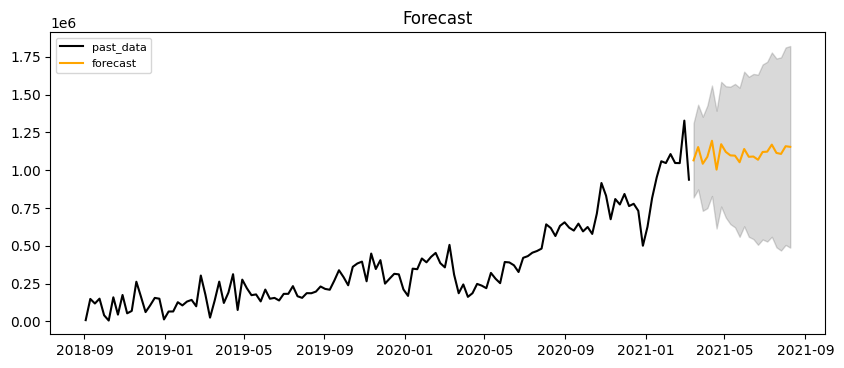

In [4]:
plot_predict_col(data_col, '2021-08-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


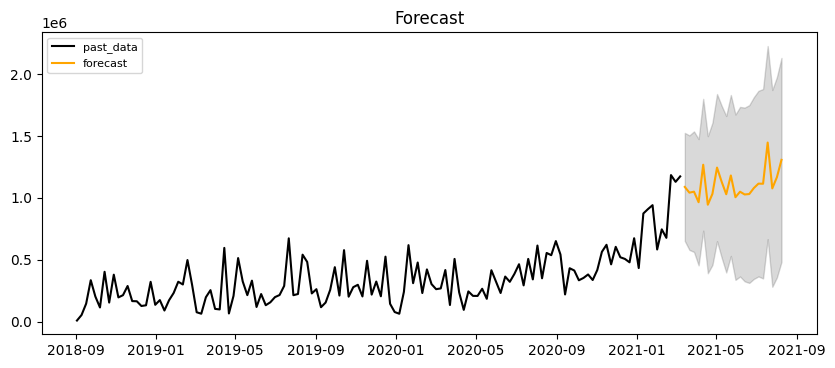

In [5]:
plot_predict_ind(data_ind, '2021-08-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_

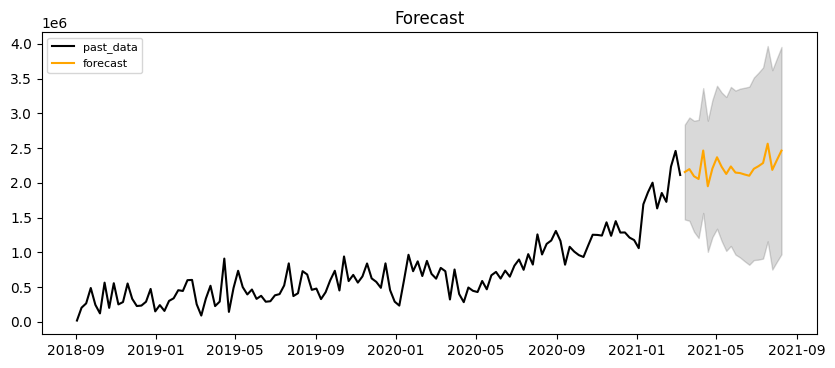

In [6]:
plot_predict_total(data_col, data_ind, '2021-08-09')

In [7]:
future_predicted_amount_df_full_data_col, future_pred_ci_full_data_col = predict_col(data_col, '2021-08-09')


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [8]:
predicted_sum_m = round(future_predicted_amount_df_full_data_col[0].sum()/1000000, 2)
lower_sum_m = round(future_pred_ci_full_data_col['lower amount'].sum()/1000000, 2)
upper_sum_m = round(future_pred_ci_full_data_col['upper amount'].sum()/1000000, 2)

In [9]:
predicted_sum_m, lower_sum_m, upper_sum_m

(24.43, 13.72, 35.15)

In [11]:
pred_sum_col(data_col, '2021-08-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


(24.43, 13.72, 35.15)

In [12]:
pred_sum_ind(data_ind, '2021-08-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


(24.41, 10.11, 38.71)

In [13]:
pred_sum_total(data_col, data_ind, '2021-08-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_

(48.84, 23.83, 73.86)